In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import brier_score_loss
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
df = pd.read_csv("data/creditcard.csv")
X = df.drop('Class', axis=1)
y = df["Class"]

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [5]:
from xgboost import XGBClassifier
xgb = XGBClassifier(eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [7]:
calibrated_sigmoid = CalibratedClassifierCV(xgb, method="sigmoid", cv=5)
calibrated_isotonic = CalibratedClassifierCV(xgb, method="isotonic", cv=5)

calibrated_sigmoid.fit(X_train, y_train)
calibrated_isotonic.fit(X_train, y_train)

,estimator,"XGBClassifier...ree=None, ...)"
,method,'isotonic'
,cv,5
,n_jobs,None
,ensemble,'auto'
,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None


In [8]:
probs_raw = xgb.predict_proba(X_test)[:,1]
probs_sigmoid = calibrated_sigmoid.predict_proba(X_test)[:,1]
probs_isotonic = calibrated_isotonic.predict_proba(X_test)[:,1]
print(probs_raw)

[4.8707868e-08 5.3604898e-09 5.2431311e-05 ... 3.1249476e-07 1.1574583e-06
 1.4255968e-07]


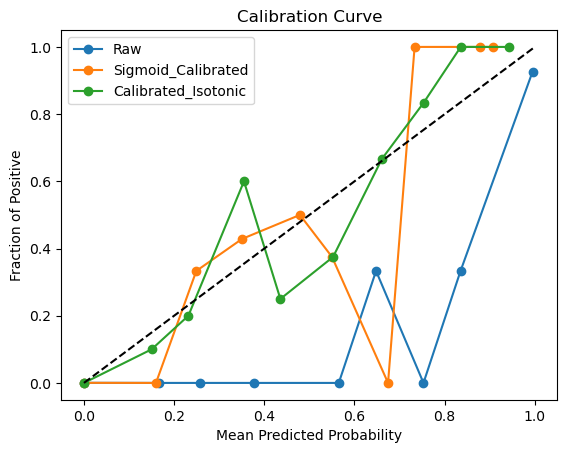

In [9]:
for probs, label in [(probs_raw,"Raw"), (probs_sigmoid,"Sigmoid_Calibrated"), (probs_isotonic,"Calibrated_Isotonic")]:
    frac_pos, mean_pred = calibration_curve(y_test, probs, n_bins=10)
    plt.plot(mean_pred, frac_pos, marker="o", label=label)
plt.plot([0,1],[0,1],"k--")
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positive")
plt.legend()
plt.title("Calibration Curve")
plt.show()

In [10]:
print(f"Brier score loss (Raw): {brier_score_loss(y_test, probs_raw)}")
print(f"Brier score loss (Sigmoid): {brier_score_loss(y_test, probs_sigmoid)}")
print(f"Brier score loss (Isotonic): {brier_score_loss(y_test, probs_isotonic)}")

Brier score loss (Raw): 0.0005175502841246912
Brier score loss (Sigmoid): 0.00042615154621378367
Brier score loss (Isotonic): 0.0004223069297358208
